# Sprint
## 機械学習スクラッチ ロジスティック回帰
スクラッチでロジスティック回帰を実装した後、学習と検証を行なっていきます。

ロジスティック回帰のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

以下に雛形を用意してあります。このScratchLogisticRegressionクラスにコードを書き加えていってください。推定関係のメソッドは線形回帰と異なり、ラベルを出力するpredictメソッドと、確率を出力するpredict_probaメソッドの2種類を作成します。

In [1]:
import numpy as np
import time
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    C : int
      正則化パラメータの逆数
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr, C, no_bias, verbose):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.C = C
        self.no_bias = no_bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # preparing
        ## check bias 
        X_biased = self._check_bias(X)
        ## check val_bias
        if X_val is not None:
            X_val_biased = self._check_bias(X_val)
        ## reshape y
        y_reshaped = y.reshape(-1, 1)
        ## reshape y_val
        if y_val is not None:
            y_val_reshaped = y_val.reshape(-1, 1)


        ## initial theta = [[0], [0], ..., [0]]
        self.coef_ = np.random.randn(X_biased.shape[1], 1)

        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print('start learning with process')
        
        start_time = time.time()

        # loop learning
        for i in range(self.iter):
            ## calc hypothesis
            hypothesis = self._logistic_hypothesis(X_biased)

            ## add loss
            self.loss[i] = self._get_loss(hypothesis, y_reshaped)

            ## calc error
            error = self._get_error(hypothesis, y_reshaped)

            ## gradient descent
            self.coef_ = self._gradient_descent(X_biased, error)

            ## validation
            if (X_val is not None) and (y_val is not None):
                ## calc val_hypothesis
                hypothesis_val = self._logistic_hypothesis(X_val_biased)

                ### add val_loss
                self.val_loss[i] = self._get_loss(hypothesis_val, y_val_reshaped)
            
            ## output process
            if self.verbose:
                print(f'{i+1} loss : train: {self.loss[i]}, valid: {self.val_loss[i]}')
        
        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f'Done! elapsed time: {elapsed_time:.5f}s')

    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        # preparing
        ## check bias 
        X_biased = self._check_bias(X)

        # predict probability of y
        pred_proba =  self._logistic_hypothesis(X_biased)
        # round to predict y
        pred = (lambda x:(x*2+1)//2)(pred_proba).astype(np.int32)

        return pred

    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        # preparing
        ## check bias 
        X_biased = self._check_bias(X)

        # predict probability of y
        pred_proba = self._logistic_hypothesis(X_biased)

        return pred_proba

    def _logistic_hypothesis(self, X):
        """
        ロジスティック回帰の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰の仮定関数による推定結果

        """
        linear_h = np.matmul(X, self.coef_)

        h = self._sigmoid(linear_h)

        return h

    def _sigmoid(self, X):
        """
        シグモイド関数の計算結果を返す

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, 1)
            線形回帰における仮定関数の計算結果

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            シグモイド関数の計算結果
        """
        exp_term = np.exp(-X)

        s = 1 / (1+exp_term)

        return s

    def _gradient_descent(self, X, error):
        """
        パラメータベクトルの値を更新する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        error : 次の形のndarray, shape (n_samples, 1)
            予測値と正解値の差

        Returns
        -------
        new_coef_ : 次の形のndarray, shape (n_samples, 1)
            更新された新たなパラメータベクトル
        """
        # m : number of samples
        m = X.shape[0]

        # calc
        ## Regularization term
        reg_term = np.concatenate((np.zeros((1, 1)), (self.coef_[1:] / (self.C*m))), axis=0)
        ## new param
        new_coef_ = self.coef_ - (((self.lr * np.matmul(X.T, error)) / m) + reg_term) 
        
        return new_coef_

    def _get_error(self, hypothesis, y):
        """
        誤差ベクトルを求める

        Parameters
        ----------
        hypothesis : 次の形のndarray, shape (n_samples, 1)
            予測値ベクトル
        y : 次の形のndarray, shape (n_samples, 1)
            パラメータベクトル

        Returns
        -------
        error: 次の形のndarray, shape (n_samples, 1)
            誤差ベクトル
        """
        error = hypothesis - y

        return error

    def _check_bias(self, v):
        """
        no_biasフラグに従い、ベクトルにバイアス項をよしなにする

        Parameters
        ----------
        v : 次の形のndarray, shape (*, n_features)
            ベクトル

        Returns
        ----------
        v_biased : 次の形のndarray, shape (*, n_features+1)
            バイアス項を追加したりしなかったりしたベクトル
        """
        m = v.shape[0]

        if not self.no_bias:
            v_biased = np.concatenate((np.ones((m, 1)), v), axis=1)
        else:
            v_biased = v

        return v_biased

    def _get_loss(self, y_pred, y):
        """
        目的関数（損失関数）の計算

        Parameters
        ----------
        y_pred : 次の形のndarray, shape (n_samples,)
            推定した値
        y : 次の形のndarray, shape (n_samples,)
            正解値

        Returns
        ----------
        loss : numpy.float
            目的関数（損失関数）
        """
        # m : number of samples
        m = y.shape[0]

        # calc
        ## y_true = 1
        log_positive_sum = np.sum(y * np.log(y_pred))
        ## y_true = 0
        log_negative_sum = np.sum((1-y) * np.log(1-y_pred))
        ## Regularization term (except theta_0)
        reg_term_sum = np.sum(self.coef_[1:]**2)

        loss = ((-log_positive_sum-log_positive_sum) / m) + (reg_term_sum / (2*m*self.C))

        return loss

# 【問題1】
## 仮定関数
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。

ロジスティック回帰の仮定関数は、線形回帰の仮定関数を **シグモイド関数** に通したものです。シグモイド関数は以下の式で表されます。

$$
g(z) = \frac{1}{1+e^{−z}}
$$

線形回帰の仮定関数は次の式でした。

$$
h_\theta(x) = \theta^T \cdot x
$$

まとめて書くと、ロジスティック回帰の仮定関数は次のようになります。

$$
h_\theta(x) = \frac{1}{1+e^{−\theta^T \cdot x}}
$$

$x$: 特徴量ベクトル

$θ$: パラメータ（重み）ベクトル

```python
    def _logistic_hypothesis(self, X):
        """
        ロジスティック回帰の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰の仮定関数による推定結果

        """
        linear_h = np.matmul(X, self.coef_)

        h = self._sigmoid(linear_h)

        return h

    def _sigmoid(self, X):
        """
        シグモイド関数の計算結果を返す

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, 1)
            線形回帰における仮定関数の計算結果

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            シグモイド関数の計算結果
        """
        exp_term = np.exp(-X)

        s = 1 / (1+exp_term)

        return s
```

# 【問題2】
## 最急降下法
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。

$$
\theta_j := \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}\\
\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)}  ,j = 0\\
\frac{\partial J(\theta)}{\partial \theta_j} = \biggl(\frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)} \biggr) + \frac{λ}{m}\theta_j　 ,j\geq 1
$$

$α$: 学習率

$i$: サンプルのインデックス

$j$: 特徴量のインデックス

$m$: 入力されるデータの数

$h_θ()$: 仮定関数

$x$: 特徴量ベクトル

$θ$: パラメータ（重み）ベクトル

$x(i)$: i番目のサンプルの特徴量ベクトル

$y(i)$: i番目のサンプルの正解ラベル

$θ_j$: j番目のパラメータ（重み）

$λ$: 正則化パラメータ

```python
    def _gradient_descent(self, X, error):
        """
        パラメータベクトルの値を更新する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        error : 次の形のndarray, shape (n_samples, 1)
            予測値と正解値の差

        Returns
        -------
        new_coef_ : 次の形のndarray, shape (n_samples, 1)
            更新された新たなパラメータベクトル
        """
        # m : number of samples
        m = X.shape[0]

        # calc
        ## Regularization term
        reg_term = np.concatenate((np.zeros((1, 1)), ((self.C * self.coef_[1:]) / m)), axis=0)
        ## new param
        new_coef_ = self.coef_ - (((self.lr * np.matmul(X.T, error)) / m) + reg_term) 
        
        return new_coef_    
```

# 【問題3】
## 推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。

仮定関数$h_θ(x)$の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。

```python
    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        # preparing
        ## check bias 
        X_biased = self._check_bias(X)

        # predict probability of y
        pred_proba =  self._logistic_hypothesis(X_biased)
        # round to predict y
        pred = (lambda x:(x*2+1)//2)(pred_proba).astype(np.int32)

        return pred
    
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        # preparing
        ## check bias 
        X_biased = self._check_bias(X)

        # predict probability of y
        pred_proba = self._logistic_hypothesis(X_biased)

        return pred_proba
```

# 【問題4】
## 目的関数
以下の数式で表されるロジスティック回帰の **目的関数（損失関数）** を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。

なお、この数式には正則化項が含まれています。

$$
J(\theta)=  \frac{1}{m}  \sum_{i=1}^{m}[−y^{(i)} log(h_θ(x^{(i)})) − (1−y^{(i)}) log(1−h_θ(x^{(i)}))] +
\frac{λ}{2m}\sum_{j=1}^n
θ^2_j.\\
$$

$m$: 入力されるデータの数

$h_θ()$: 仮定関数

$x$: 特徴量ベクトル

$θ$: パラメータ（重み）ベクトル

$x(i)$: i番目のサンプルの特徴量ベクトル

$y(i)$: i番目のサンプルの正解ラベル

$θ_j$: j番目のパラメータ（重み）

$n$: 特徴量の数

$λ$: 正則化パラメータ

```python
    def _get_loss(self, y_pred, y):
        """
        目的関数（損失関数）の計算

        Parameters
        ----------
        y_pred : 次の形のndarray, shape (n_samples,)
            推定した値
        y : 次の形のndarray, shape (n_samples,)
            正解値

        Returns
        ----------
        loss : numpy.float
            目的関数（損失関数）
        """
        # m : number of samples
        m = y.shape[0]

        # calc
        ## y_true = 1
        log_positive_sum = np.sum(y * np.log(y_pred))
        ## y_true = 0
        log_negative_sum = np.sum((1-y) * np.log(1-y_pred))
        ## Regularization term (except theta_0)
        reg_term_sum = np.sum(self.coef_[1:]**2)

        loss = ((-log_positive_sum-log_positive_sum) / m) + ((self.C*reg_term_sum) / (2*m))

        return loss
```

# 【問題5】
## 学習と推定
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。

AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

特徴量についてはまず'sepal_length', 'petal_length'を用いて分類する。

In [2]:
import pandas as pd
from sklearn.datasets import load_iris
data = load_iris()

# 説明変数
X = pd.DataFrame(data=data.get('data'), 
    columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])

# 目的変数
Y = pd.DataFrame(data=data.get('target'),
    columns=['Species'])

# 列の抽出
df_iris = pd.concat((X, Y), axis=1)[['sepal_length', 'petal_length', 'Species']]
# Species: virgicolor = 1, verginica = 2
df_iris = df_iris[df_iris['Species'] != 0]

display(df_iris)

,sepal_length,petal_length,Species
50,7.0,4.7,1
51,6.4,4.5,1
52,6.9,4.9,1
53,5.5,4.0,1
54,6.5,4.6,1
...,...,...,...
145,6.7,5.2,2
146,6.3,5.0,2
147,6.5,5.2,2
148,6.2,5.4,2


In [3]:
from sklearn.model_selection import train_test_split

# get numpy array
X_values = df_iris[['sepal_length', 'petal_length']].values
# get numpy array and replace Species: virgicolor = 0, verginica = 1
y_values = df_iris['Species'].values-1

X_train, X_val, y_train, y_val = train_test_split(X_values, y_values)

In [4]:
# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)

print(X_train_std)
print(X_val_std)

[[ 0.13984155  0.85344476]
 [-1.15100351 -0.64675111]
 [ 0.94661971  0.72842844]
 [ 0.78526407  0.85344476]
 [ 0.62390844 -0.39671846]
 [-0.98964787 -0.52173479]
 [ 1.59204223  1.10347741]
 [-0.34422535 -0.52173479]
 [ 0.46255281 -0.39671846]
 [-0.98964787 -0.0216695 ]
 [ 0.13984155  1.35351005]
 [ 1.59204223  1.35351005]
 [ 1.10797534  0.97846109]
 [-2.1191373  -2.02193066]
 [-0.82829224  0.10334683]
 [-0.18286972 -0.39671846]
 [ 1.26933097 -0.27170214]
 [ 0.30119718  0.72842844]
 [ 0.94661971  1.22849373]
 [-1.95778167 -1.77189801]
 [-0.82829224 -1.02180008]
 [-0.82829224 -1.77189801]
 [-0.18286972 -1.1468164 ]
 [ 0.13984155 -0.64675111]
 [ 0.30119718  0.47839579]
 [ 0.30119718  0.85344476]
 [-1.6350704  -1.27183272]
 [ 0.13984155  0.85344476]
 [ 0.78526407 -0.64675111]
 [ 1.59204223  1.47852638]
 [ 0.30119718 -0.52173479]
 [-0.98964787 -0.89678375]
 [-1.15100351 -1.1468164 ]
 [-0.18286972 -0.27170214]
 [-0.50558098 -0.89678375]
 [-0.82829224 -0.89678375]
 [ 0.30119718 -0.77176743]
 

In [5]:
# learn and predict
clf = ScratchLogisticRegression(num_iter=10000, lr=0.01, C=10, no_bias=False, verbose=True)
clf.fit(X_train_std, y_train, X_val_std, y_val)

8344439811741554, valid: 0.33864730973160195
9698 loss : train: 0.38344439810402664, valid: 0.3386473097309689
9699 loss : train: 0.3834443980906613, valid: 0.33864730973033735
9700 loss : train: 0.38344439807731945, valid: 0.33864730972970714
9701 loss : train: 0.38344439806400116, valid: 0.33864730972907836
9702 loss : train: 0.38344439805070635, valid: 0.33864730972845086
9703 loss : train: 0.38344439803743485, valid: 0.338647309727825
9704 loss : train: 0.38344439802418684, valid: 0.33864730972720036
9705 loss : train: 0.38344439801096203, valid: 0.3386473097265772
9706 loss : train: 0.3834443979977606, valid: 0.3386473097259554
9707 loss : train: 0.3834443979845824, valid: 0.338647309725335
9708 loss : train: 0.3834443979714275, valid: 0.33864730972471613
9709 loss : train: 0.38344439795829566, valid: 0.3386473097240984
9710 loss : train: 0.38344439794518714, valid: 0.3386473097234822
9711 loss : train: 0.38344439793210155, valid: 0.33864730972286733
9712 loss : train: 0.383444397

In [6]:
# scratch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred_proba = clf.predict_proba(X_val_std).flatten()
y_pred = clf.predict(X_val_std).flatten()
print(clf.coef_)
print(y_pred_proba)
print(y_pred)
print(y_val)

# 損失関数
## m : number of samples
m = y_val.shape[0]

## y_true = 1
log_positive_sum = np.sum(y_val * np.log(y_pred_proba))
## y_true = 0
log_negative_sum = np.sum((1-y_val) * np.log(1-y_pred_proba))
## Regularization term (except theta_0)
reg_term_sum = np.sum(clf.coef_[1:]**2)

loss = ((-log_positive_sum-log_positive_sum) / m) + (reg_term_sum / (2*m*10))

print(f'scratch loss:       {loss}')
print(f'scratch accuracy:   {accuracy_score(y_val, y_pred)}')
print(f'scratch precision:  {precision_score(y_val, y_pred)}')
print(f'scratch recall:     {recall_score(y_val, y_pred)}')
print(f'scratch f1:         {f1_score(y_val, y_pred)}')
print(f'scratch confusion matrix:\n {confusion_matrix(y_val, y_pred)}')

[[0.06186919]
 [0.21141917]
 [1.12509362]]
[0.24560096 0.37059158 0.72695181 0.30767959 0.21396608 0.51675726
 0.93835284 0.45612763 0.04676367 0.21467336 0.65146251 0.20271522
 0.63484208 0.36961236 0.56751909 0.8515126  0.58622087 0.33175721
 0.55174142 0.94792883 0.55278004 0.06742683 0.89380071 0.90313085
 0.52422289]
[0 0 1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1]
[0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 0]
scratch loss:       0.338647309592597
scratch accuracy:   0.84
scratch precision:  0.7857142857142857
scratch recall:     0.9166666666666666
scratch f1:         0.8461538461538461
scratch confusion matrix:
 [[10  3]
 [ 1 11]]


In [7]:
# skelearnのモデルを利用
from sklearn.linear_model import LogisticRegression

clf_sk = LogisticRegression(max_iter=10000, C=0.1).fit(X_train_std, y_train)
sk_pred_proba = clf_sk.predict_proba(X_val_std)[:, 1]
sk_pred = clf_sk.predict(X_val_std)
print(clf_sk.intercept_, clf_sk.coef_)
print(sk_pred_proba)
print(sk_pred)
print(y_val)

# 損失関数
## m : number of samples
m = y_val.shape[0]

## y_true = 1
log_positive_sum = np.sum(y_val * np.log(sk_pred_proba))
## y_true = 0
log_negative_sum = np.sum((1-y_val) * np.log(1-sk_pred_proba))
## Regularization term (except theta_0)
reg_term_sum = np.sum(clf_sk.coef_**2)

loss = ((-log_positive_sum-log_positive_sum) / m) + (reg_term_sum / (2*m*10))

print(f'sklearn loss:       {loss}')
print(f'sklearn accuracy:   {accuracy_score(y_val, sk_pred)}')
print(f'sklearn precision:  {precision_score(y_val, sk_pred)}')
print(f'sklearn recall:     {recall_score(y_val, sk_pred)}')
print(f'sklearn f1:         {f1_score(y_val, sk_pred)}')
print(f'sklearn confusion matrix:\n {confusion_matrix(y_val, sk_pred)}')

[0.06186266] [[0.21141876 1.12509452]]
[0.24559966 0.37058995 0.72695061 0.30767805 0.21396483 0.51675561
 0.9383525  0.45612602 0.04676332 0.21467218 0.65146103 0.20271404
 0.63484051 0.36961064 0.56751737 0.85151184 0.58621932 0.33175574
 0.55173981 0.94792856 0.55277853 0.06742635 0.89380014 0.90313031
 0.52422113]
[0 0 1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1]
[0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 0]
sklearn loss:       0.33864899403168114
sklearn accuracy:   0.84
sklearn precision:  0.7857142857142857
sklearn recall:     0.9166666666666666
sklearn f1:         0.8461538461538461
sklearn confusion matrix:
 [[10  3]
 [ 1 11]]


sklearn実装のロジスティック回帰モデルとほぼ同じ結果となった。

実装の違いとしては、スクラッチではバイアス項が`coef_`に含まれているが、sklearnの物では別のアトリビュート(`intercept_`)に格納されていることがあげられる。

# 【問題6】
## 学習曲線のプロット
学習曲線を見て損失が適切に下がっているかどうか確認してください。

In [8]:
import matplotlib.pyplot as plt
def plot_model_loss(model):
    train_loss = model.loss
    val_loss = model.val_loss

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.set_xlabel('iter')
    ax.set_ylabel('loss')
    ax.set_title('model loss')

    ax = plt.plot(range(train_loss.shape[0]), train_loss, label='train_loss')
    ax = plt.plot(range(val_loss.shape[0]), val_loss, label='val_loss')
    
    plt.legend()
    plt.show()

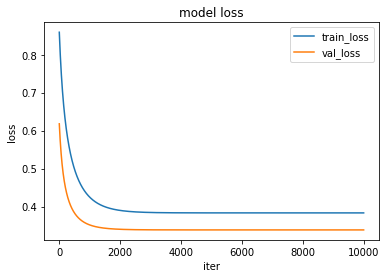

In [9]:
# 可視化
%matplotlib inline
plot_model_loss(clf)

順調に損失関数の値は下がり、2000iteration付近で収束した。

# 【問題7】
## 決定領域の可視化
決定領域を可視化してください。

In [10]:
# validation
x_min, x_max = X_val_std[:, 0].min() - 1, X_val_std[:, 0].max() + 1
y_min, y_max = X_val_std[:, 1].min() - 1, X_val_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

print(xx)
print(yy)

[[-2.95778167 -2.94778167 -2.93778167 ...  3.69221833  3.70221833
   3.71221833]
 [-2.95778167 -2.94778167 -2.93778167 ...  3.69221833  3.70221833
   3.71221833]
 [-2.95778167 -2.94778167 -2.93778167 ...  3.69221833  3.70221833
   3.71221833]
 ...
 [-2.95778167 -2.94778167 -2.93778167 ...  3.69221833  3.70221833
   3.71221833]
 [-2.95778167 -2.94778167 -2.93778167 ...  3.69221833  3.70221833
   3.71221833]
 [-2.95778167 -2.94778167 -2.93778167 ...  3.69221833  3.70221833
   3.71221833]]
[[-3.39697963 -3.39697963 -3.39697963 ... -3.39697963 -3.39697963
  -3.39697963]
 [-3.38697963 -3.38697963 -3.38697963 ... -3.38697963 -3.38697963
  -3.38697963]
 [-3.37697963 -3.37697963 -3.37697963 ... -3.37697963 -3.37697963
  -3.37697963]
 ...
 [ 3.08302037  3.08302037  3.08302037 ...  3.08302037  3.08302037
   3.08302037]
 [ 3.09302037  3.09302037  3.09302037 ...  3.09302037  3.09302037
   3.09302037]
 [ 3.10302037  3.10302037  3.10302037 ...  3.10302037  3.10302037
   3.10302037]]


In [11]:
XX = xx.ravel()
YY = yy.ravel()

X_tmp = np.array([XX, YY]).T
print(X_tmp)

Z = clf.predict(X_tmp).reshape(xx.shape)
print(Z)

[[-2.95778167 -3.39697963]
 [-2.94778167 -3.39697963]
 [-2.93778167 -3.39697963]
 ...
 [ 3.69221833  3.10302037]
 [ 3.70221833  3.10302037]
 [ 3.71221833  3.10302037]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


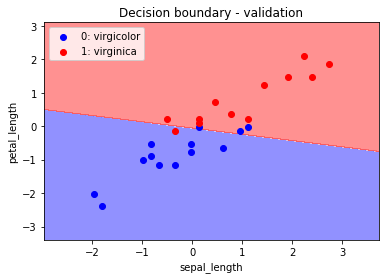

In [12]:
import matplotlib.pyplot as plt

X_val_0 = X_val_std[np.where(y_val==0)]
X_val_1 = X_val_std[np.where(y_val==1)]

%matplotlib inline
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Decision boundary - validation')
plt.xlabel('sepal_length')
plt.ylabel('petal_length')

plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.5)
plt.scatter(X_val_0[:, 0], X_val_0[:, 1], c='blue', label="0: virgicolor")
plt.scatter(X_val_1[:, 0], X_val_1[:, 1], c='red', label="1: virginica")

plt.legend()
plt.show()

In [13]:
# training
x_min, x_max = X_train_std[:, 0].min() - 1, X_train_std[:, 0].max() + 1
y_min, y_max = X_train_std[:, 1].min() - 1, X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

XX = xx.ravel()
YY = yy.ravel()

X_tmp = np.array([XX, YY]).T

Z = clf.predict(X_tmp).reshape(xx.shape)

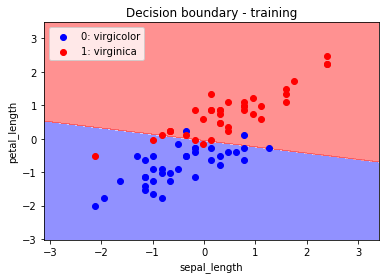

In [14]:
X_train_0 = X_train_std[np.where(y_train==0)]
X_train_1 = X_train_std[np.where(y_train==1)]

%matplotlib inline
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Decision boundary - training')
plt.xlabel('sepal_length')
plt.ylabel('petal_length')

plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.5)
plt.scatter(X_train_0[:, 0], X_train_0[:, 1], c='blue', label="0: virgicolor")
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], c='red', label="1: virginica")

plt.legend()
plt.show()

# 【問題8】（アドバンス課題）
## 重みの保存
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。pickleモジュールやNumPyのnp.savezを利用します。

[pickle — Python オブジェクトの直列化 — Python 3.7.4 ドキュメント](https://docs.python.org/ja/3/library/pickle.html)

[numpy.savez — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html)

In [15]:
# pickle
import pickle
filename = 'saved_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [16]:
# numpy.savez - Attributesを保存する
np.savez('np_savez', clf.coef_, clf.loss, clf.val_loss)

In [17]:
# 読み込んで比較する
clf1 = pickle.load(open(filename, 'rb'))
clf2 = ScratchLogisticRegression(num_iter=10000, lr=0.01, C=0.1, no_bias=False, verbose=True)
npz = np.load('np_savez.npz')
clf2.coef_, clf2.loss, clf.val_loss = [npz[x] for x in npz.files]

# パラメータ確認
print(f'clf.coef_  : {clf.coef_.flatten()}')
print(f'clf1.coef_ : {clf1.coef_.flatten()}')
print(f'clf2.coef_ : {clf2.coef_.flatten()}')

# 予測結果確認
y_pred_clf = clf.predict_proba(X_val_std).flatten()
y_pred_clf1 = clf1.predict_proba(X_val_std).flatten()
y_pred_clf2 = clf2.predict_proba(X_val_std).flatten()
print(f'clf_pred  == clf1_pred : {np.allclose(y_pred_clf, y_pred_clf1)}')
print(f'clf1_pred == clf2_pred : {np.allclose(y_pred_clf1, y_pred_clf2)}')
print(f'clf2_pred == clf_pred  : {np.allclose(y_pred_clf2, y_pred_clf)}')

clf.coef_  : [0.06186919 0.21141917 1.12509362]
clf1.coef_ : [0.06186919 0.21141917 1.12509362]
clf2.coef_ : [0.06186919 0.21141917 1.12509362]
clf_pred  == clf1_pred : True
clf1_pred == clf2_pred : True
clf2_pred == clf_pred  : True
